# **1. 导入数据**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
dataset = load_boston()
x_data = dataset.data # 导入所有特征变量
y_data = dataset.target # 导入目标值（房价）
name_data = dataset.feature_names #导入特征名

# **2. 可视化MEDV**

**是否服从正态分布？建立线性模型是否合理？**

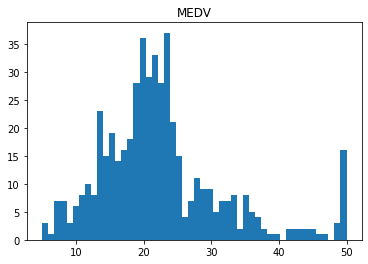

In [ ]:
plt.hist(y_data,bins=50)
plt.title('MEDV')
plt.show()

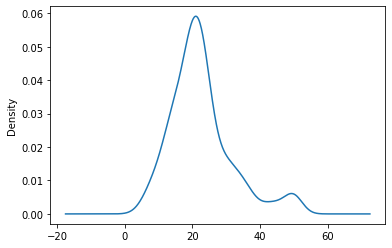

In [ ]:
pd.Series(y_data).plot.density()

# **3. 验证方法正确性**

## **3.1 函数设定**

In [ ]:
## quadratic sum
def qua_sum(x):
  return (x**2).sum()
 
## f function
def f(X, Y, beta):
  result = X.dot(beta)
  L2 = qua_sum(Y - result)
  return L2

## loss-function 
def loss(X, Y, beta, lamb):
  return 0.5*f(X, Y, beta)/len(X) + lamb * np.abs(beta).sum()
 
## derivation function of first part of loss-function
def der(X, Y, beta):
  grad = -1/len(X) * X.T.dot(Y - X.dot(beta))
  return grad
 
## beta -> beta_hat
def hat(X, Y, beta, mu):
  hat = beta - mu * der(X, Y, beta)
  return hat
 
## once iteration function
def plus(X, Y, beta, mu, lamb):
  beta_hat = hat(X, Y, beta, mu)
  tmp = 1 - lamb*mu/np.abs(beta_hat)
  beta_plus1 = np.maximum(tmp, 0) * beta_hat
  #print("loss:", loss(X, Y, beta_plus1, lamb))
  return beta_plus1

## whole iteration function
def iter(X, Y, beta0, mu, lamb, epsilon):
  beta1 = plus(X, Y, beta0, mu, lamb)
  while np.sqrt(qua_sum(beta1 - beta0))/(np.sqrt(qua_sum(beta0)) + epsilon) > epsilon:
    beta0 = beta1
    beta1 = plus(X, Y, beta0, mu, lamb)
  #print("loss:", loss(X, Y, beta1, lamb))
  #print(beta1)
  return beta1

## **3.2 使用整个数据集来迭代求解，对比迭代法和sklearn的结果**

**设定lambda=1，先使用迭代法求解** 

In [ ]:
np.random.seed(1234)
beta0 = np.random.randn(13) ## 初始化参数为正态随机

mu = 1e-6
epsilon = 1e-9
s = 1
#lamb = 10 ** (-3 + 0.1*s)
lamb = 1

In [ ]:
import time
time_start = time.time()
 
beta_test = iter(x_data, y_data, beta0, mu, lamb, epsilon)
print("loss:", loss(x_data, y_data, beta_test, lamb))
print(beta_test)
 
time_end = time.time()
print('time cost:', time_end - time_start, 's')

loss: 19.00821522468574
[-0.05446614  0.04811154  0.          0.          0.          4.1003301
  0.03197575 -0.26920298  0.09034675 -0.00689792 -0.0840442   0.01602389
 -0.55877206]
time cost: 294.32954120635986 s


**再与sklearn中lasso结果对比**

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=lamb, fit_intercept=False)
clf.fit(x_data, y_data)

Lasso(alpha=1, copy_X=True, fit_intercept=False, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
print(clf.coef_)

[-0.05447639  0.04807717  0.          0.          0.          4.10641268
  0.03181277 -0.27104961  0.09063498 -0.00692123 -0.08497132  0.01601536
 -0.55817918]


In [ ]:
loss(x_data, y_data, clf.coef_, lamb)

19.008203237449806

**可以看到迭代法的结果和sklearn中lasso的结果基本一致，这说明迭代法的实现过程是正确并有效的，虽然迭代法的时间消费远远高于sklearn中的算法。不过，正确性被保证，我们终于可以进入交叉验证阶段选取超参数lambda了**

# **4. lambda的选取：网格法与交叉验证**

**先将data分为train和valid，在train中进行交叉验证选择lambda，将选择好的lambda在train上训练，最后在valid上测试**

## **4.1 train data and validation data**

In [ ]:
## train and validation
np.random.seed(1234)
shuffle_index = np.random.permutation(len(x_data)) ## 打乱顺序后的index

x_data_train = x_data[shuffle_index][0:round(0.8*len(x_data))]
x_data_valid = x_data[shuffle_index][round(0.8*len(x_data)):]
print(len(x_data_train), len(x_data_valid))

y_data_train = y_data[shuffle_index][0:round(0.8*len(x_data))]
y_data_valid = y_data[shuffle_index][round(0.8*len(x_data)):]
print(len(y_data_train), len(y_data_valid))

405 101
405 101


## **4.2 cross-validation**

In [ ]:
num_folds = 5
s_choices = [i for i in range(61)]
## 一些超参数
mu = 1e-6
epsilon = 1e-9
 
X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(x_data_train, num_folds)
y_train_folds = np.array_split(y_data_train, num_folds)

## 存放mse
s_to_mse = {}
mean_mse = {}

import time
time_start = time.time()

for s in s_choices:
    lamb = 10 ** (-3 + 0.1*s)
    s_to_mse[s] = []
    for i in range(num_folds):
        np.random.seed(1234)
        beta0 = np.random.randn(13) ## 每次迭代的初始参数

        X_tmp = X_train_folds.copy() ## copy在pop过后不会影响原来的X_train_folds
        y_tmp = y_train_folds.copy()
        
        X_test_tmp = X_tmp.pop(i) ## pop返回的一项为test
        X_train_tmp = np.concatenate(X_tmp, axis=0) ## 剩下的 num_folds - 1 项为train 是一个len为 num_folds - 1 的list，每个元素是一个二维数组
                                                    ## 传入concatenate中连接成一个array
        y_test_tmp = y_tmp.pop(i)
        y_train_tmp = np.concatenate(y_tmp)   ## 是一个len为 num_folds - 1 的list，但每个元素是一个一维向量，所以concatenate不能加入axis参数
        
        beta_lasso = iter(X_train_tmp, y_train_tmp, beta0, mu, lamb, epsilon)
        print('s=', s, 'coef :', beta_lasso)
        print('\n')
        mse = f(X_test_tmp, y_test_tmp, beta_lasso)/len(X_test_tmp)
        
        s_to_mse[s].append(mse)

time_end = time.time()
print('cross-validation time cost:', time_end - time_start, 's')

# Print out the computed mses
for k in sorted(s_to_mse):
  mean_mse[k] = np.mean(s_to_mse[k])
  print('s = %d, mean_test_MSE = %f' % (k, mean_mse[k]))

s= 0 coef : [ 0.01061545  0.03734542  0.02223181  1.79605136 -2.60182762  6.38760464
 -0.03324323 -1.01971688  0.0623334  -0.01076665 -0.53044474  0.01704302
 -0.27983636]


s= 0 coef : [-3.15034149e-02  2.47133787e-02  1.95723539e-02  2.36186979e+00
 -6.20185117e+00  6.87312935e+00 -3.04626241e-03 -7.60959837e-01
  4.48335066e-02 -7.79152162e-03 -6.09766437e-01  1.09458795e-02
 -3.71218212e-01]


s= 0 coef : [-0.06682113  0.03244859  0.01856107  2.53112051 -2.97275028  6.40551396
 -0.0066322  -0.74107583  0.11097959 -0.01067694 -0.58151147  0.0138499
 -0.35823552]


s= 0 coef : [-0.09228729  0.03020523  0.07011217  2.79131947 -3.92749766  6.69003899
 -0.02887022 -0.94458909  0.15761426 -0.00964773 -0.57147352  0.0133681
 -0.36565064]


s= 0 coef : [-0.03715017  0.0254442   0.02293178  2.01685916 -3.18425571  6.71091656
 -0.02573099 -0.88034166  0.07430892 -0.01123686 -0.61937124  0.01482146
 -0.26641815]


s= 1 coef : [ 0.01060873  0.03735668  0.0218818   1.79276224 -2.53453038  6.383

**可以看到随着s增大，有越来越多的系数收敛到0，但随之而来的问题是mse的增大，因为越多的0意味着越少的变量在发挥作用**

Text(0.5, 0, 's')

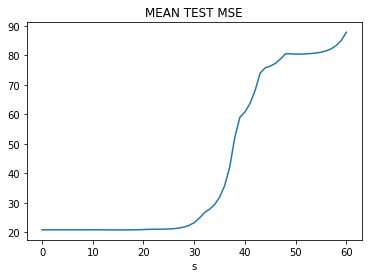

In [ ]:
import pandas as pd
pd.Series(mean_mse).plot()
plt.title('MEAN TEST MSE')
plt.xlabel('s')

**选取交叉验证中平均测试集mse最小的lambda作为最优lambda**

In [ ]:
best_s = min(mean_mse, key=mean_mse.get)
print("best_s = ", best_s)
best_lamb = 10 ** (-3 + 0.1*best_s)
print("best_lambda = ", best_lamb)

best_s =  15
best_lambda =  0.03162277660168379


# **5. 将选好的超参数应用到验证集**

In [ ]:
np.random.seed(1234)
beta0 = np.random.randn(13) ## 初始化参数为正态随机

mu = 1e-6
epsilon = 1e-9

import time
time_start = time.time()

## 用best_lamb迭代
best_beta = iter(x_data_train, y_data_train, beta0, mu, best_lamb, epsilon)
mse = f(x_data_valid, y_data_valid, best_beta)/len(x_data_valid)
print('valid_mse:', mse)
 
time_end = time.time()
print('time cost:', time_end - time_start, 's')

valid_mse: 50.83008614046992
time cost: 1465.7192914485931 s


In [ ]:
## 将系数与变量名对应
import pandas as pd
beta_name = pd.DataFrame(best_beta, index=name_data, columns=['coef'])
beta_name

,coef
CRIM,-0.045198
ZN,0.030788
INDUS,0.014118
CHAS,1.685132
NOX,-0.000000
RM,6.384428
AGE,-0.021244
DIS,-0.827626
RAD,0.092990
TAX,-0.010894


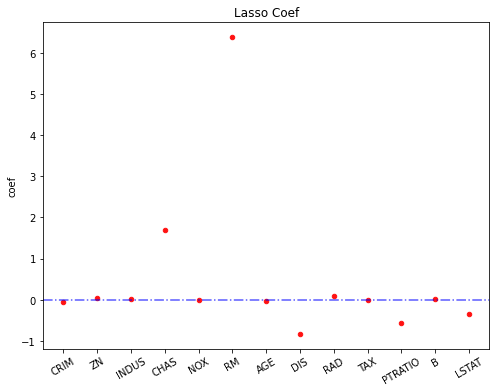

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.title('Lasso Coef')
plt.scatter(list(range(13)), best_beta, s=20, c="#ff1212", marker='o')
plt.xticks(list(range(13)), name_data, rotation=30)
plt.ylabel('coef')
plt.axhline(y=0,ls="dashdot",c="blue",alpha=0.65)#添加水平直线

plt.show()

**从表和图中可以看到系数收敛为0的变量为NOX**

# **6. 描述分析**

随着s的增大，相应的lambda也会增大，这时在loss-function中第二部分也就是对系数的限制部分的loss变大了，所以会更容易将系数收敛掉。这与交叉验证过程中所显示的结果是一致的。


通过平均mse筛选出来的最优lambda得到的lasso回归结果显示只有变量NOX的系数完全为0，虽然有一些其他变量的系数较小，但lasso的几何意义显示回归收缩的系数应该完全为0，其他较小的系数可能是由于量纲不同所引起。